# Importing

In [134]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi


# Datasets Preparation

In [135]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask)


# Masking

In [136]:
def masking (depth, temp, saline, mask):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    return (temp, saline)


# SOM

In [137]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = np.transpose(inputs)  
    inputs2 = inputs2[indx[:,0]]

    # SOM
    temp_som = SOM(m=2, n=3, dim= inputs2[0,:].size)
    temp_som.fit(inputs2)
    predictions = temp_som.predict(inputs2)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2, predictions, clusters)


# Printing

In [138]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [139]:
def plotting (depth, clusters, unique):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(1, 1, figsize=(5, 9))

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,                    
                    )
    
    cmap = plt.get_cmap('viridis', int(unique.max()+1))
    cmap.set_bad('gray')

    map.plot.pcolormesh(ax=ax, cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique}) 
    sa_vi.set_aspect(ax)
    ax.set_title('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('SOM clustering using temperature and salinity for ' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 10569 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 11.04 degrees Celsius
The mean temperature for cluster 0 is 9.01 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 22.08 g/kg
The mean salinity for cluster 0 is 16.92 g/kg 


The amount of grid boxes for cluster 1 is 8615 

The minimum temperature for cluster 1 is 7.38 degrees Celsius
The maximum temperature for cluster 1 is 10.51 degrees Celsius
The mean temperature for cluster 1 is 9.09 degrees Celsius 

The minimum salinity for cluster 1 is 24.43 g/kg
The maximum salinity for cluster 1 is 26.16 g/kg
The mean salinity for cluster 1 is 25.36 g/kg 


The amount of grid boxes for cluster 2 is 29160 

The minimum temperature for cluster 2 is 6.81 degrees Celsius
The maximum temperature for cluster 2 is 9.73 degrees Celsius
The mean temperature for cluster 2 is 8.03 degrees Celsius 

Th

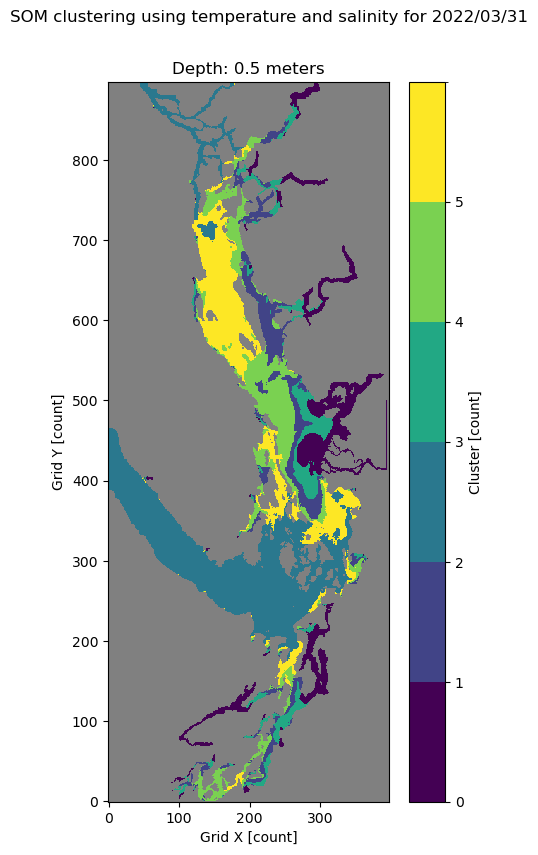

The amount of grid boxes for cluster 0 is 25795 

The minimum temperature for cluster 0 is 6.72 degrees Celsius
The maximum temperature for cluster 0 is 9.72 degrees Celsius
The mean temperature for cluster 0 is 7.98 degrees Celsius 

The minimum salinity for cluster 0 is 28.89 g/kg
The maximum salinity for cluster 0 is 31.32 g/kg
The mean salinity for cluster 0 is 30.39 g/kg 


The amount of grid boxes for cluster 1 is 15679 

The minimum temperature for cluster 1 is 7.42 degrees Celsius
The maximum temperature for cluster 1 is 10.0 degrees Celsius
The mean temperature for cluster 1 is 8.68 degrees Celsius 

The minimum salinity for cluster 1 is 26.59 g/kg
The maximum salinity for cluster 1 is 28.38 g/kg
The mean salinity for cluster 1 is 27.56 g/kg 


The amount of grid boxes for cluster 2 is 6202 

The minimum temperature for cluster 2 is 7.26 degrees Celsius
The maximum temperature for cluster 2 is 10.54 degrees Celsius
The mean temperature for cluster 2 is 9.13 degrees Celsius 

T

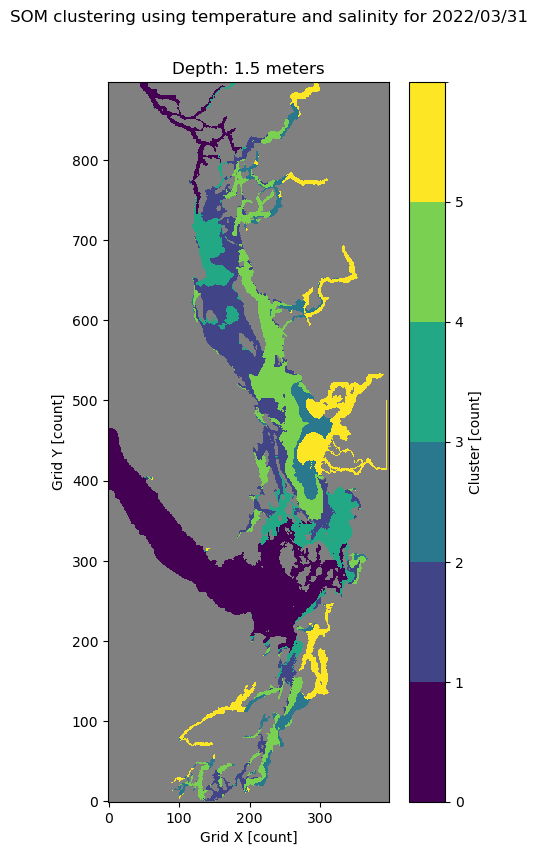

The amount of grid boxes for cluster 0 is 11893 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 11.12 degrees Celsius
The mean temperature for cluster 0 is 9.04 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 24.87 g/kg
The mean salinity for cluster 0 is 20.28 g/kg 


The amount of grid boxes for cluster 1 is 15794 

The minimum temperature for cluster 1 is 7.48 degrees Celsius
The maximum temperature for cluster 1 is 10.14 degrees Celsius
The mean temperature for cluster 1 is 8.7 degrees Celsius 

The minimum salinity for cluster 1 is 26.11 g/kg
The maximum salinity for cluster 1 is 27.68 g/kg
The mean salinity for cluster 1 is 26.89 g/kg 


The amount of grid boxes for cluster 2 is 8221 

The minimum temperature for cluster 2 is 7.0 degrees Celsius
The maximum temperature for cluster 2 is 9.58 degrees Celsius
The mean temperature for cluster 2 is 8.33 degrees Celsius 

The 

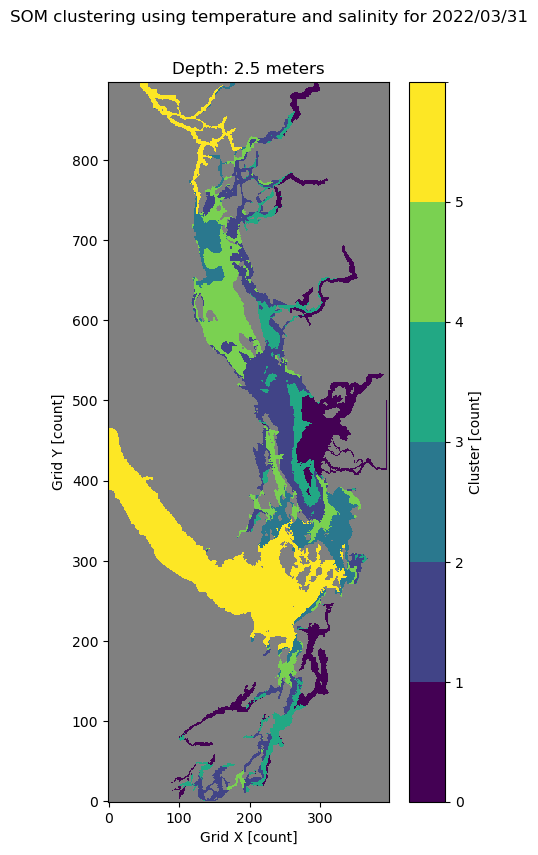

The amount of grid boxes for cluster 0 is 8860 

The minimum temperature for cluster 0 is 7.19 degrees Celsius
The maximum temperature for cluster 0 is 9.53 degrees Celsius
The mean temperature for cluster 0 is 8.32 degrees Celsius 

The minimum salinity for cluster 0 is 28.39 g/kg
The maximum salinity for cluster 0 is 29.42 g/kg
The mean salinity for cluster 0 is 28.86 g/kg 


The amount of grid boxes for cluster 1 is 16306 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 10.28 degrees Celsius
The mean temperature for cluster 1 is 8.56 degrees Celsius 

The minimum salinity for cluster 1 is 26.33 g/kg
The maximum salinity for cluster 1 is 27.72 g/kg
The mean salinity for cluster 1 is 27.04 g/kg 


The amount of grid boxes for cluster 2 is 8587 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 10.84 degrees Celsius
The mean temperature for cluster 2 is 8.83 degrees Celsius 

T

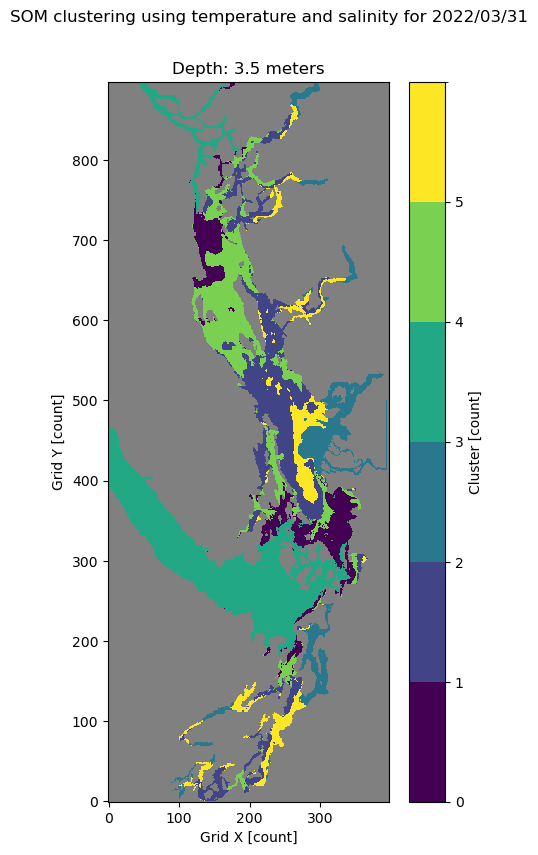

The amount of grid boxes for cluster 0 is 22132 

The minimum temperature for cluster 0 is 7.01 degrees Celsius
The maximum temperature for cluster 0 is 9.26 degrees Celsius
The mean temperature for cluster 0 is 7.93 degrees Celsius 

The minimum salinity for cluster 0 is 29.61 g/kg
The maximum salinity for cluster 0 is 31.36 g/kg
The mean salinity for cluster 0 is 30.58 g/kg 


The amount of grid boxes for cluster 1 is 11517 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 9.52 degrees Celsius
The mean temperature for cluster 1 is 8.33 degrees Celsius 

The minimum salinity for cluster 1 is 28.12 g/kg
The maximum salinity for cluster 1 is 28.97 g/kg
The mean salinity for cluster 1 is 28.46 g/kg 


The amount of grid boxes for cluster 2 is 8519 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 10.53 degrees Celsius
The mean temperature for cluster 2 is 8.73 degrees Celsius 

T

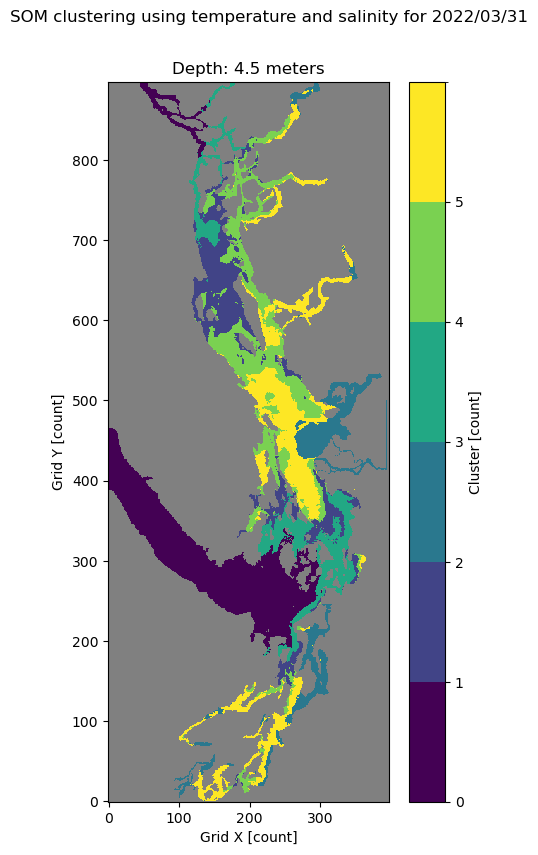

The amount of grid boxes for cluster 0 is 22252 

The minimum temperature for cluster 0 is 6.68 degrees Celsius
The maximum temperature for cluster 0 is 9.07 degrees Celsius
The mean temperature for cluster 0 is 7.92 degrees Celsius 

The minimum salinity for cluster 0 is 29.57 g/kg
The maximum salinity for cluster 0 is 31.39 g/kg
The mean salinity for cluster 0 is 30.59 g/kg 


The amount of grid boxes for cluster 1 is 10249 

The minimum temperature for cluster 1 is 7.71 degrees Celsius
The maximum temperature for cluster 1 is 10.2 degrees Celsius
The mean temperature for cluster 1 is 8.27 degrees Celsius 

The minimum salinity for cluster 1 is 28.39 g/kg
The maximum salinity for cluster 1 is 29.17 g/kg
The mean salinity for cluster 1 is 28.71 g/kg 


The amount of grid boxes for cluster 2 is 13788 

The minimum temperature for cluster 2 is 7.31 degrees Celsius
The maximum temperature for cluster 2 is 10.37 degrees Celsius
The mean temperature for cluster 2 is 8.46 degrees Celsius 



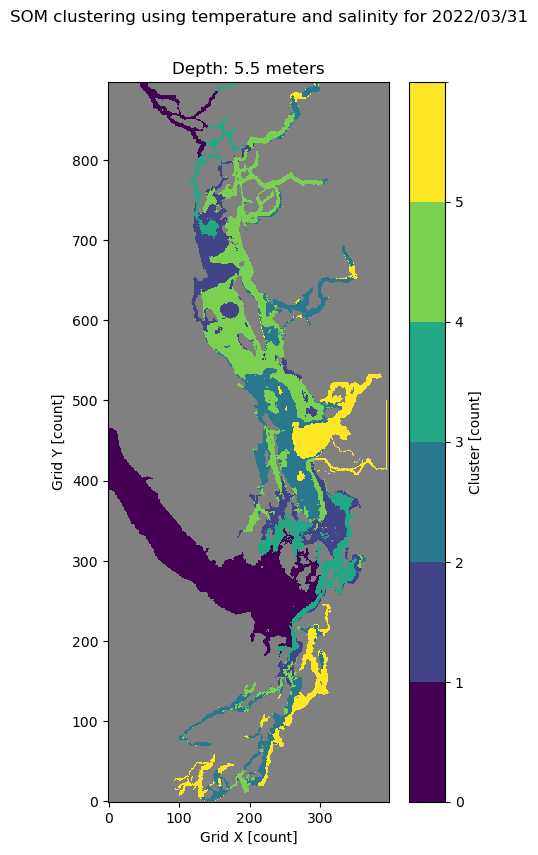

The amount of grid boxes for cluster 0 is 16123 

The minimum temperature for cluster 0 is 7.3 degrees Celsius
The maximum temperature for cluster 0 is 10.32 degrees Celsius
The mean temperature for cluster 0 is 8.33 degrees Celsius 

The minimum salinity for cluster 0 is 27.22 g/kg
The maximum salinity for cluster 0 is 28.41 g/kg
The mean salinity for cluster 0 is 27.72 g/kg 


The amount of grid boxes for cluster 1 is 17422 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 10.2 degrees Celsius
The mean temperature for cluster 1 is 8.12 degrees Celsius 

The minimum salinity for cluster 1 is 27.93 g/kg
The maximum salinity for cluster 1 is 28.72 g/kg
The mean salinity for cluster 1 is 28.33 g/kg 


The amount of grid boxes for cluster 2 is 7032 

The minimum temperature for cluster 2 is 6.32 degrees Celsius
The maximum temperature for cluster 2 is 9.04 degrees Celsius
The mean temperature for cluster 2 is 8.08 degrees Celsius 

Th

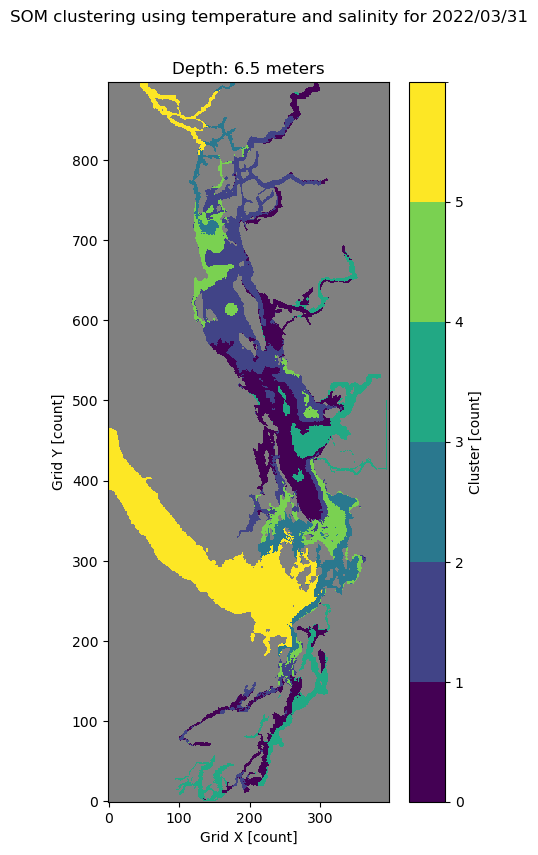

The amount of grid boxes for cluster 0 is 17925 

The minimum temperature for cluster 0 is 7.31 degrees Celsius
The maximum temperature for cluster 0 is 10.3 degrees Celsius
The mean temperature for cluster 0 is 8.31 degrees Celsius 

The minimum salinity for cluster 0 is 27.15 g/kg
The maximum salinity for cluster 0 is 28.37 g/kg
The mean salinity for cluster 0 is 27.76 g/kg 


The amount of grid boxes for cluster 1 is 22048 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 10.26 degrees Celsius
The mean temperature for cluster 1 is 8.11 degrees Celsius 

The minimum salinity for cluster 1 is 28.04 g/kg
The maximum salinity for cluster 1 is 28.96 g/kg
The mean salinity for cluster 1 is 28.44 g/kg 


The amount of grid boxes for cluster 2 is 7166 

The minimum temperature for cluster 2 is 6.19 degrees Celsius
The maximum temperature for cluster 2 is 9.03 degrees Celsius
The mean temperature for cluster 2 is 7.96 degrees Celsius 

T

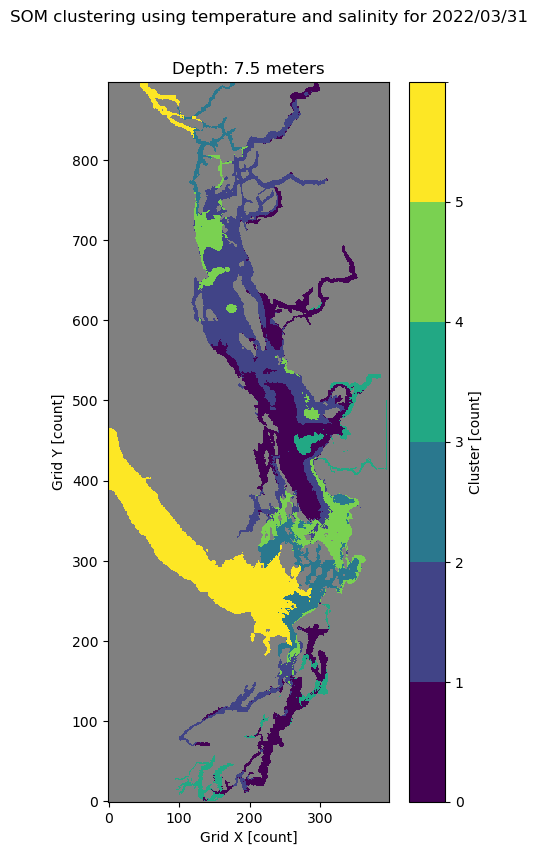

The amount of grid boxes for cluster 0 is 2234 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 9.68 degrees Celsius
The mean temperature for cluster 0 is 8.4 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 27.43 g/kg
The mean salinity for cluster 0 is 22.65 g/kg 


The amount of grid boxes for cluster 1 is 21113 

The minimum temperature for cluster 1 is 7.4 degrees Celsius
The maximum temperature for cluster 1 is 9.35 degrees Celsius
The mean temperature for cluster 1 is 8.0 degrees Celsius 

The minimum salinity for cluster 1 is 27.95 g/kg
The maximum salinity for cluster 1 is 28.7 g/kg
The mean salinity for cluster 1 is 28.4 g/kg 


The amount of grid boxes for cluster 2 is 6128 

The minimum temperature for cluster 2 is 6.15 degrees Celsius
The maximum temperature for cluster 2 is 8.77 degrees Celsius
The mean temperature for cluster 2 is 8.04 degrees Celsius 

The minimu

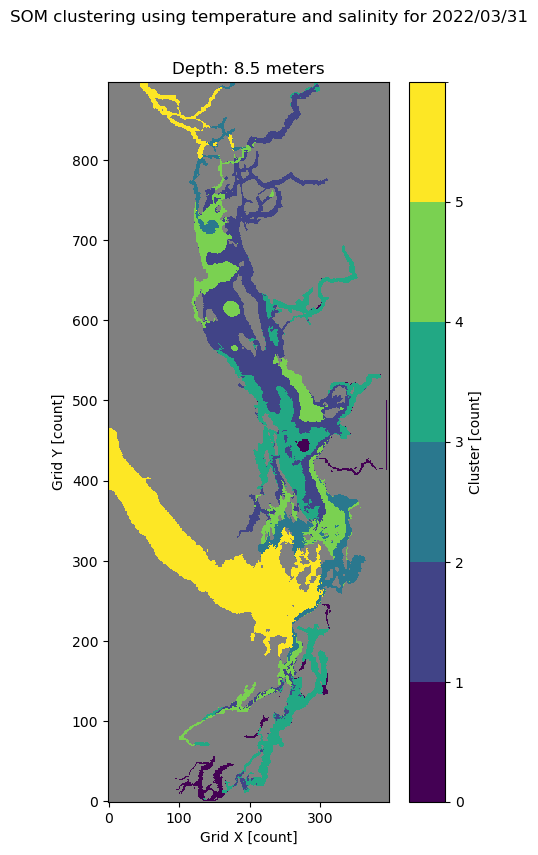

The amount of grid boxes for cluster 0 is 17708 

The minimum temperature for cluster 0 is 7.34 degrees Celsius
The maximum temperature for cluster 0 is 8.4 degrees Celsius
The mean temperature for cluster 0 is 7.87 degrees Celsius 

The minimum salinity for cluster 0 is 30.11 g/kg
The maximum salinity for cluster 0 is 31.51 g/kg
The mean salinity for cluster 0 is 30.8 g/kg 


The amount of grid boxes for cluster 1 is 7025 

The minimum temperature for cluster 1 is 7.57 degrees Celsius
The maximum temperature for cluster 1 is 8.84 degrees Celsius
The mean temperature for cluster 1 is 8.08 degrees Celsius 

The minimum salinity for cluster 1 is 28.97 g/kg
The maximum salinity for cluster 1 is 29.66 g/kg
The mean salinity for cluster 1 is 29.34 g/kg 


The amount of grid boxes for cluster 2 is 20160 

The minimum temperature for cluster 2 is 7.39 degrees Celsius
The maximum temperature for cluster 2 is 8.45 degrees Celsius
The mean temperature for cluster 2 is 7.92 degrees Celsius 

The 

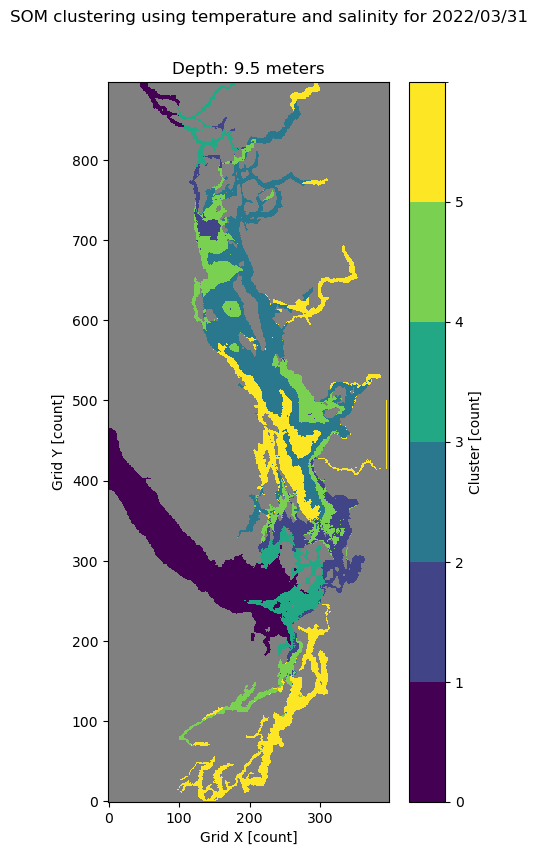

The amount of grid boxes for cluster 0 is 5621 

The minimum temperature for cluster 0 is 6.38 degrees Celsius
The maximum temperature for cluster 0 is 9.28 degrees Celsius
The mean temperature for cluster 0 is 8.24 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 28.21 g/kg
The mean salinity for cluster 0 is 26.72 g/kg 


The amount of grid boxes for cluster 1 is 22441 

The minimum temperature for cluster 1 is 7.38 degrees Celsius
The maximum temperature for cluster 1 is 9.18 degrees Celsius
The mean temperature for cluster 1 is 7.99 degrees Celsius 

The minimum salinity for cluster 1 is 28.23 g/kg
The maximum salinity for cluster 1 is 28.99 g/kg
The mean salinity for cluster 1 is 28.68 g/kg 


The amount of grid boxes for cluster 2 is 5739 

The minimum temperature for cluster 2 is 6.22 degrees Celsius
The maximum temperature for cluster 2 is 8.64 degrees Celsius
The mean temperature for cluster 2 is 7.92 degrees Celsius 

The m

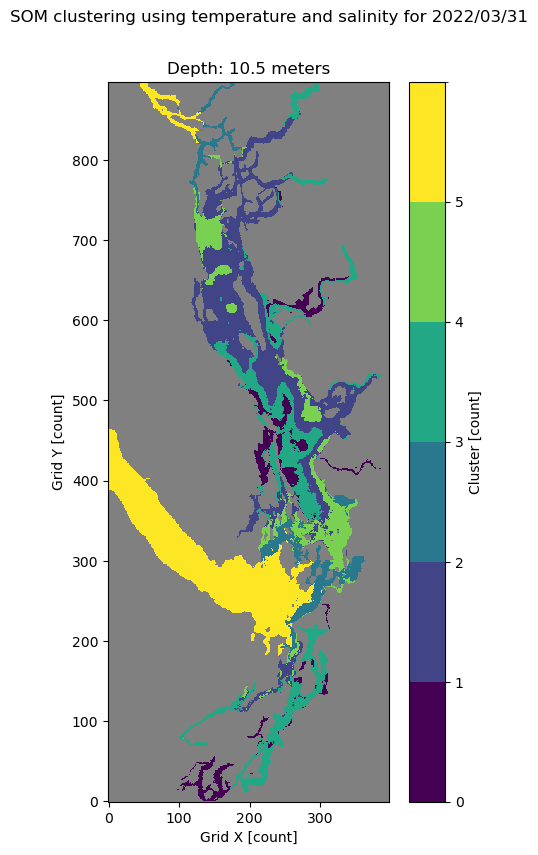

The amount of grid boxes for cluster 0 is 5742 

The minimum temperature for cluster 0 is 6.32 degrees Celsius
The maximum temperature for cluster 0 is 8.64 degrees Celsius
The mean temperature for cluster 0 is 7.89 degrees Celsius 

The minimum salinity for cluster 0 is 29.57 g/kg
The maximum salinity for cluster 0 is 30.2 g/kg
The mean salinity for cluster 0 is 29.93 g/kg 


The amount of grid boxes for cluster 1 is 11894 

The minimum temperature for cluster 1 is 7.73 degrees Celsius
The maximum temperature for cluster 1 is 8.67 degrees Celsius
The mean temperature for cluster 1 is 8.12 degrees Celsius 

The minimum salinity for cluster 1 is 28.82 g/kg
The maximum salinity for cluster 1 is 29.27 g/kg
The mean salinity for cluster 1 is 29.01 g/kg 


The amount of grid boxes for cluster 2 is 22451 

The minimum temperature for cluster 2 is 7.37 degrees Celsius
The maximum temperature for cluster 2 is 8.22 degrees Celsius
The mean temperature for cluster 2 is 7.91 degrees Celsius 

The

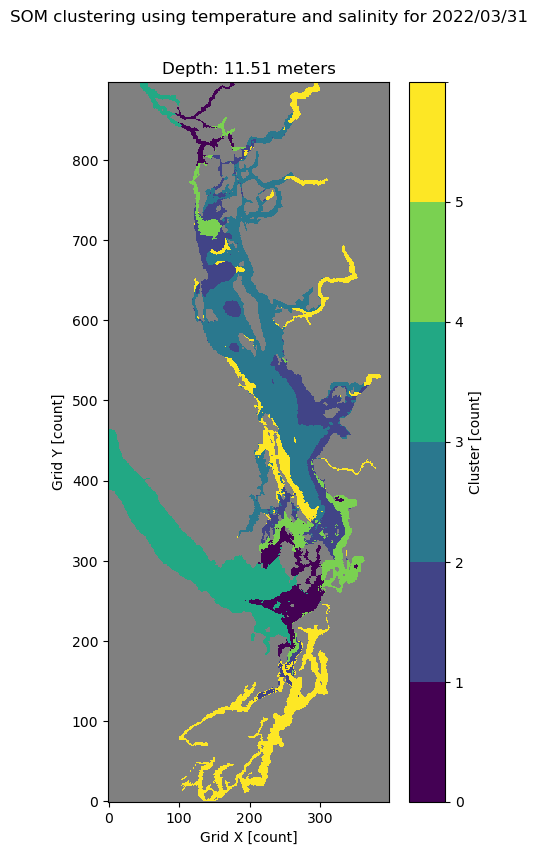

The amount of grid boxes for cluster 0 is 10856 

The minimum temperature for cluster 0 is 7.85 degrees Celsius
The maximum temperature for cluster 0 is 10.5 degrees Celsius
The mean temperature for cluster 0 is 8.64 degrees Celsius 

The minimum salinity for cluster 0 is 27.89 g/kg
The maximum salinity for cluster 0 is 29.35 g/kg
The mean salinity for cluster 0 is 28.52 g/kg 


The amount of grid boxes for cluster 1 is 10582 

The minimum temperature for cluster 1 is 7.71 degrees Celsius
The maximum temperature for cluster 1 is 10.18 degrees Celsius
The mean temperature for cluster 1 is 8.15 degrees Celsius 

The minimum salinity for cluster 1 is 28.99 g/kg
The maximum salinity for cluster 1 is 29.74 g/kg
The mean salinity for cluster 1 is 29.24 g/kg 


The amount of grid boxes for cluster 2 is 18507 

The minimum temperature for cluster 2 is 7.26 degrees Celsius
The maximum temperature for cluster 2 is 8.33 degrees Celsius
The mean temperature for cluster 2 is 7.85 degrees Celsius 



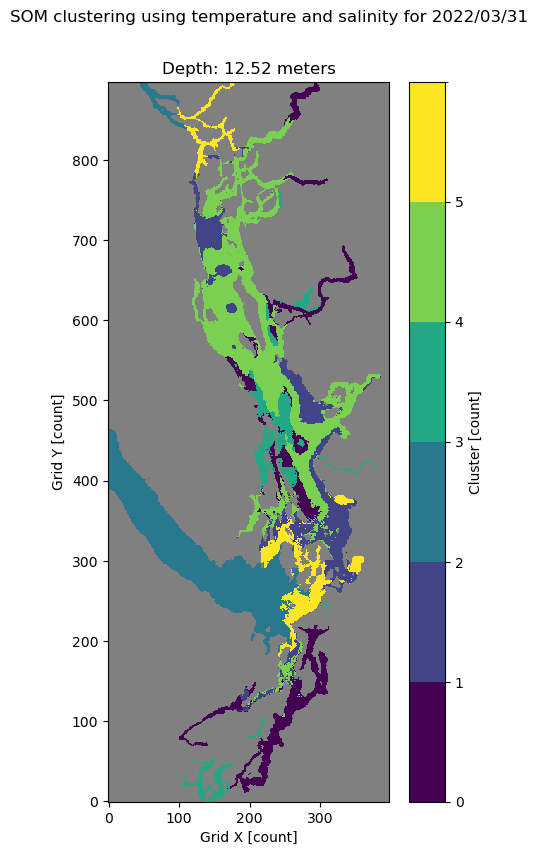

The amount of grid boxes for cluster 0 is 5656 

The minimum temperature for cluster 0 is 6.56 degrees Celsius
The maximum temperature for cluster 0 is 8.65 degrees Celsius
The mean temperature for cluster 0 is 7.88 degrees Celsius 

The minimum salinity for cluster 0 is 29.68 g/kg
The maximum salinity for cluster 0 is 30.32 g/kg
The mean salinity for cluster 0 is 30.02 g/kg 


The amount of grid boxes for cluster 1 is 13324 

The minimum temperature for cluster 1 is 7.86 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.26 degrees Celsius 

The minimum salinity for cluster 1 is 28.91 g/kg
The maximum salinity for cluster 1 is 29.64 g/kg
The mean salinity for cluster 1 is 29.12 g/kg 


The amount of grid boxes for cluster 2 is 12641 

The minimum temperature for cluster 2 is 6.42 degrees Celsius
The maximum temperature for cluster 2 is 10.53 degrees Celsius
The mean temperature for cluster 2 is 8.58 degrees Celsius 



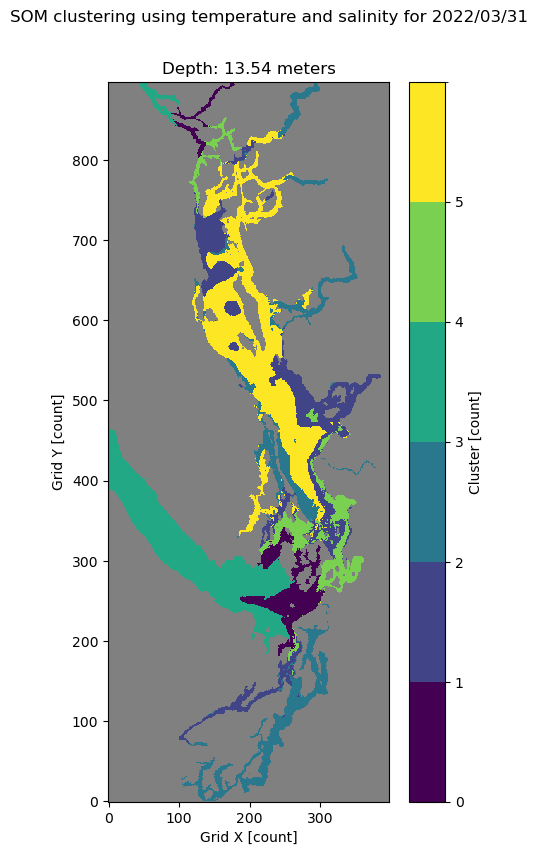

The amount of grid boxes for cluster 0 is 16831 

The minimum temperature for cluster 0 is 7.22 degrees Celsius
The maximum temperature for cluster 0 is 8.27 degrees Celsius
The mean temperature for cluster 0 is 7.82 degrees Celsius 

The minimum salinity for cluster 0 is 30.21 g/kg
The maximum salinity for cluster 0 is 31.73 g/kg
The mean salinity for cluster 0 is 30.89 g/kg 


The amount of grid boxes for cluster 1 is 6936 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 8.44 degrees Celsius
The mean temperature for cluster 1 is 7.99 degrees Celsius 

The minimum salinity for cluster 1 is 29.07 g/kg
The maximum salinity for cluster 1 is 29.73 g/kg
The mean salinity for cluster 1 is 29.44 g/kg 


The amount of grid boxes for cluster 2 is 23297 

The minimum temperature for cluster 2 is 6.42 degrees Celsius
The maximum temperature for cluster 2 is 8.53 degrees Celsius
The mean temperature for cluster 2 is 7.93 degrees Celsius 

Th

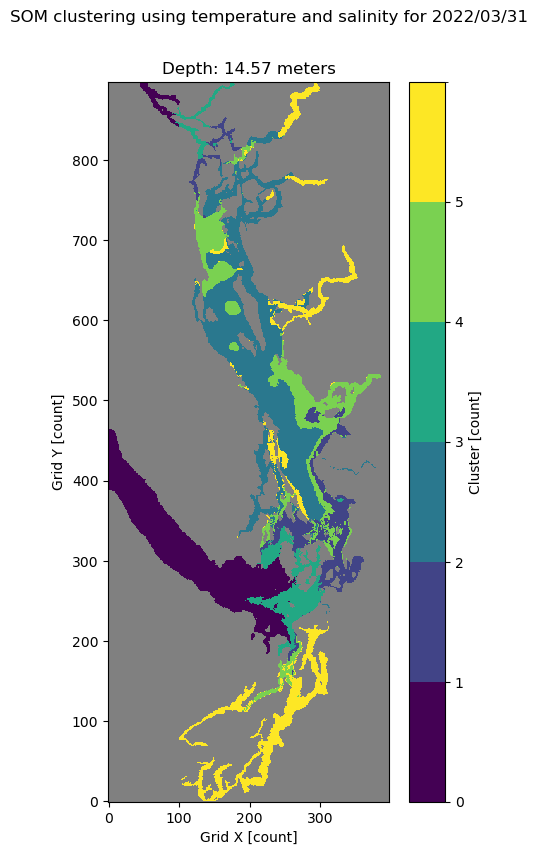

The amount of grid boxes for cluster 0 is 5319 

The minimum temperature for cluster 0 is 6.82 degrees Celsius
The maximum temperature for cluster 0 is 8.25 degrees Celsius
The mean temperature for cluster 0 is 7.87 degrees Celsius 

The minimum salinity for cluster 0 is 29.77 g/kg
The maximum salinity for cluster 0 is 30.42 g/kg
The mean salinity for cluster 0 is 30.1 g/kg 


The amount of grid boxes for cluster 1 is 11995 

The minimum temperature for cluster 1 is 7.82 degrees Celsius
The maximum temperature for cluster 1 is 8.71 degrees Celsius
The mean temperature for cluster 1 is 8.18 degrees Celsius 

The minimum salinity for cluster 1 is 29.08 g/kg
The maximum salinity for cluster 1 is 29.8 g/kg
The mean salinity for cluster 1 is 29.24 g/kg 


The amount of grid boxes for cluster 2 is 11606 

The minimum temperature for cluster 2 is 6.42 degrees Celsius
The maximum temperature for cluster 2 is 10.53 degrees Celsius
The mean temperature for cluster 2 is 8.76 degrees Celsius 

The

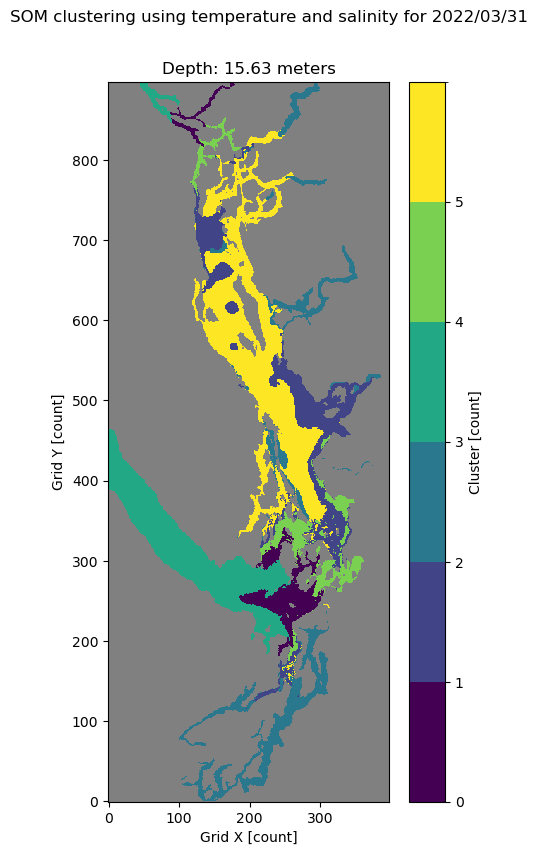

The amount of grid boxes for cluster 0 is 11501 

The minimum temperature for cluster 0 is 8.22 degrees Celsius
The maximum temperature for cluster 0 is 10.49 degrees Celsius
The mean temperature for cluster 0 is 8.79 degrees Celsius 

The minimum salinity for cluster 0 is 20.27 g/kg
The maximum salinity for cluster 0 is 29.64 g/kg
The mean salinity for cluster 0 is 28.74 g/kg 


The amount of grid boxes for cluster 1 is 12424 

The minimum temperature for cluster 1 is 7.81 degrees Celsius
The maximum temperature for cluster 1 is 8.78 degrees Celsius
The mean temperature for cluster 1 is 8.18 degrees Celsius 

The minimum salinity for cluster 1 is 29.12 g/kg
The maximum salinity for cluster 1 is 29.89 g/kg
The mean salinity for cluster 1 is 29.29 g/kg 


The amount of grid boxes for cluster 2 is 4911 

The minimum temperature for cluster 2 is 6.93 degrees Celsius
The maximum temperature for cluster 2 is 8.19 degrees Celsius
The mean temperature for cluster 2 is 7.86 degrees Celsius 

T

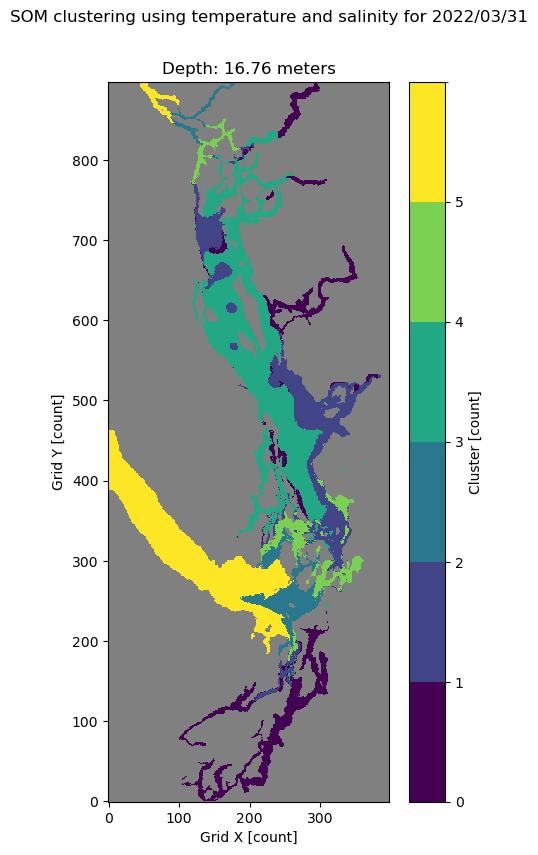

The amount of grid boxes for cluster 0 is 24033 

The minimum temperature for cluster 0 is 6.48 degrees Celsius
The maximum temperature for cluster 0 is 9.13 degrees Celsius
The mean temperature for cluster 0 is 7.99 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.22 g/kg
The mean salinity for cluster 0 is 28.76 g/kg 


The amount of grid boxes for cluster 1 is 4775 

The minimum temperature for cluster 1 is 7.57 degrees Celsius
The maximum temperature for cluster 1 is 8.4 degrees Celsius
The mean temperature for cluster 1 is 7.93 degrees Celsius 

The minimum salinity for cluster 1 is 29.28 g/kg
The maximum salinity for cluster 1 is 29.93 g/kg
The mean salinity for cluster 1 is 29.64 g/kg 


The amount of grid boxes for cluster 2 is 15630 

The minimum temperature for cluster 2 is 7.16 degrees Celsius
The maximum temperature for cluster 2 is 8.22 degrees Celsius
The mean temperature for cluster 2 is 7.78 degrees Celsius 

The m

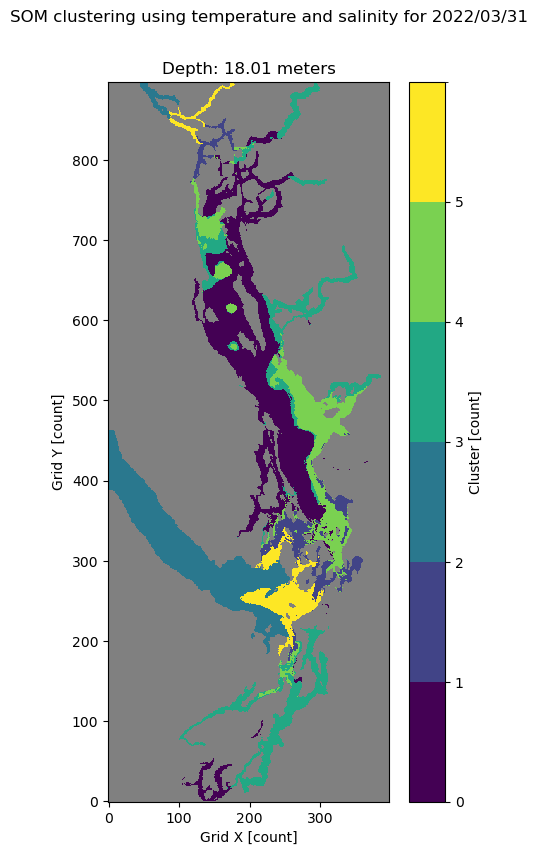

The amount of grid boxes for cluster 0 is 13237 

The minimum temperature for cluster 0 is 8.22 degrees Celsius
The maximum temperature for cluster 0 is 10.33 degrees Celsius
The mean temperature for cluster 0 is 8.75 degrees Celsius 

The minimum salinity for cluster 0 is 28.17 g/kg
The maximum salinity for cluster 0 is 29.76 g/kg
The mean salinity for cluster 0 is 29.19 g/kg 


The amount of grid boxes for cluster 1 is 3836 

The minimum temperature for cluster 1 is 7.65 degrees Celsius
The maximum temperature for cluster 1 is 8.67 degrees Celsius
The mean temperature for cluster 1 is 8.02 degrees Celsius 

The minimum salinity for cluster 1 is 29.45 g/kg
The maximum salinity for cluster 1 is 29.94 g/kg
The mean salinity for cluster 1 is 29.65 g/kg 


The amount of grid boxes for cluster 2 is 16152 

The minimum temperature for cluster 2 is 7.15 degrees Celsius
The maximum temperature for cluster 2 is 8.18 degrees Celsius
The mean temperature for cluster 2 is 7.77 degrees Celsius 

T

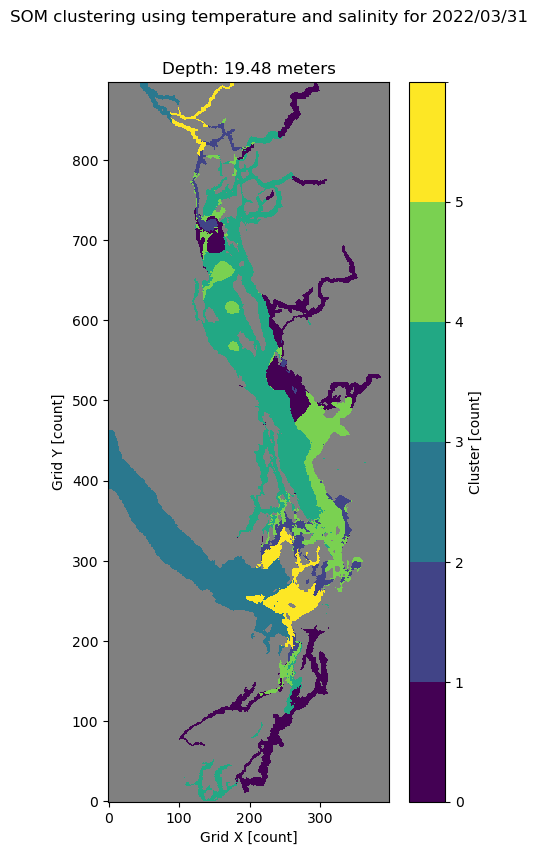

The amount of grid boxes for cluster 0 is 15417 

The minimum temperature for cluster 0 is 7.14 degrees Celsius
The maximum temperature for cluster 0 is 8.17 degrees Celsius
The mean temperature for cluster 0 is 7.75 degrees Celsius 

The minimum salinity for cluster 0 is 30.46 g/kg
The maximum salinity for cluster 0 is 32.1 g/kg
The mean salinity for cluster 0 is 31.04 g/kg 


The amount of grid boxes for cluster 1 is 3058 

The minimum temperature for cluster 1 is 7.67 degrees Celsius
The maximum temperature for cluster 1 is 8.67 degrees Celsius
The mean temperature for cluster 1 is 8.03 degrees Celsius 

The minimum salinity for cluster 1 is 29.5 g/kg
The maximum salinity for cluster 1 is 29.98 g/kg
The mean salinity for cluster 1 is 29.71 g/kg 


The amount of grid boxes for cluster 2 is 13347 

The minimum temperature for cluster 2 is 8.23 degrees Celsius
The maximum temperature for cluster 2 is 10.23 degrees Celsius
The mean temperature for cluster 2 is 8.76 degrees Celsius 

The

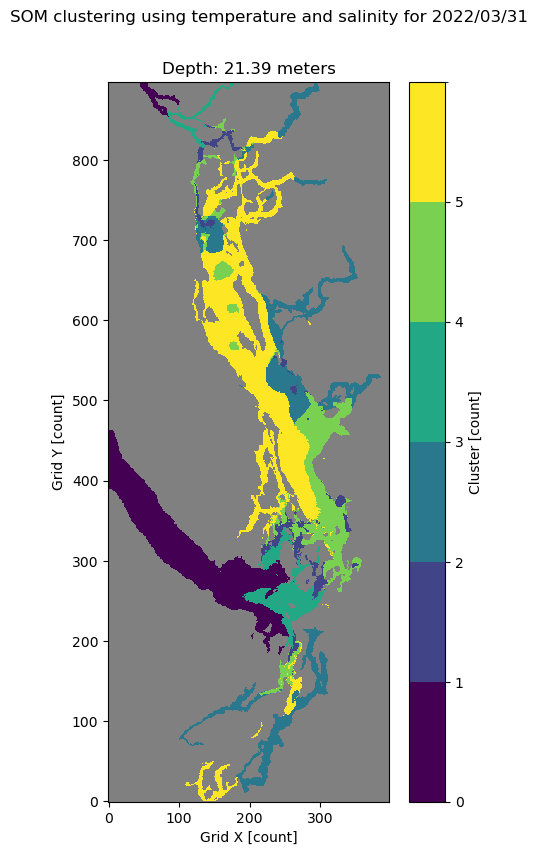

The amount of grid boxes for cluster 0 is 3234 

The minimum temperature for cluster 0 is 7.44 degrees Celsius
The maximum temperature for cluster 0 is 8.28 degrees Celsius
The mean temperature for cluster 0 is 7.86 degrees Celsius 

The minimum salinity for cluster 0 is 30.05 g/kg
The maximum salinity for cluster 0 is 30.49 g/kg
The mean salinity for cluster 0 is 30.21 g/kg 


The amount of grid boxes for cluster 1 is 8866 

The minimum temperature for cluster 1 is 8.17 degrees Celsius
The maximum temperature for cluster 1 is 10.2 degrees Celsius
The mean temperature for cluster 1 is 8.89 degrees Celsius 

The minimum salinity for cluster 1 is 28.86 g/kg
The maximum salinity for cluster 1 is 29.91 g/kg
The mean salinity for cluster 1 is 29.55 g/kg 


The amount of grid boxes for cluster 2 is 9147 

The minimum temperature for cluster 2 is 8.14 degrees Celsius
The maximum temperature for cluster 2 is 10.18 degrees Celsius
The mean temperature for cluster 2 is 8.43 degrees Celsius 

The

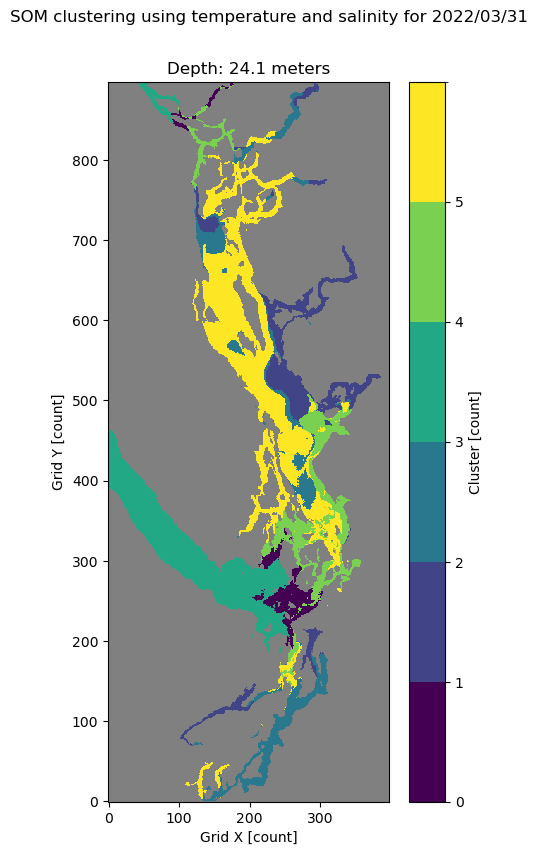

The amount of grid boxes for cluster 0 is 9121 

The minimum temperature for cluster 0 is 8.29 degrees Celsius
The maximum temperature for cluster 0 is 10.21 degrees Celsius
The mean temperature for cluster 0 is 8.7 degrees Celsius 

The minimum salinity for cluster 0 is 26.61 g/kg
The maximum salinity for cluster 0 is 29.78 g/kg
The mean salinity for cluster 0 is 29.15 g/kg 


The amount of grid boxes for cluster 1 is 8409 

The minimum temperature for cluster 1 is 8.04 degrees Celsius
The maximum temperature for cluster 1 is 9.92 degrees Celsius
The mean temperature for cluster 1 is 8.66 degrees Celsius 

The minimum salinity for cluster 1 is 29.52 g/kg
The maximum salinity for cluster 1 is 30.25 g/kg
The mean salinity for cluster 1 is 29.7 g/kg 


The amount of grid boxes for cluster 2 is 3210 

The minimum temperature for cluster 2 is 7.52 degrees Celsius
The maximum temperature for cluster 2 is 8.01 degrees Celsius
The mean temperature for cluster 2 is 7.82 degrees Celsius 

The m

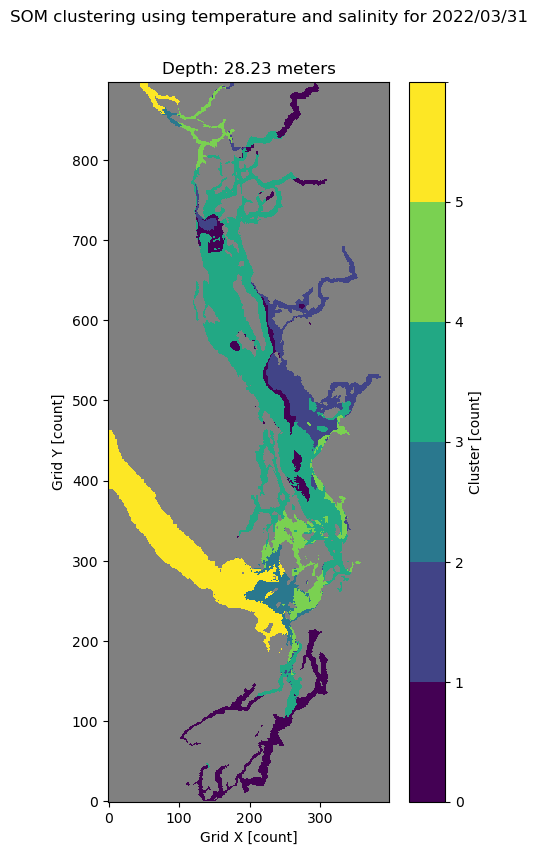

The amount of grid boxes for cluster 0 is 11812 

The minimum temperature for cluster 0 is 8.31 degrees Celsius
The maximum temperature for cluster 0 is 10.21 degrees Celsius
The mean temperature for cluster 0 is 8.85 degrees Celsius 

The minimum salinity for cluster 0 is 28.78 g/kg
The maximum salinity for cluster 0 is 30.02 g/kg
The mean salinity for cluster 0 is 29.7 g/kg 


The amount of grid boxes for cluster 1 is 1631 

The minimum temperature for cluster 1 is 7.57 degrees Celsius
The maximum temperature for cluster 1 is 8.92 degrees Celsius
The mean temperature for cluster 1 is 7.94 degrees Celsius 

The minimum salinity for cluster 1 is 29.93 g/kg
The maximum salinity for cluster 1 is 30.33 g/kg
The mean salinity for cluster 1 is 30.1 g/kg 


The amount of grid boxes for cluster 2 is 13306 

The minimum temperature for cluster 2 is 7.13 degrees Celsius
The maximum temperature for cluster 2 is 7.87 degrees Celsius
The mean temperature for cluster 2 is 7.64 degrees Celsius 

The

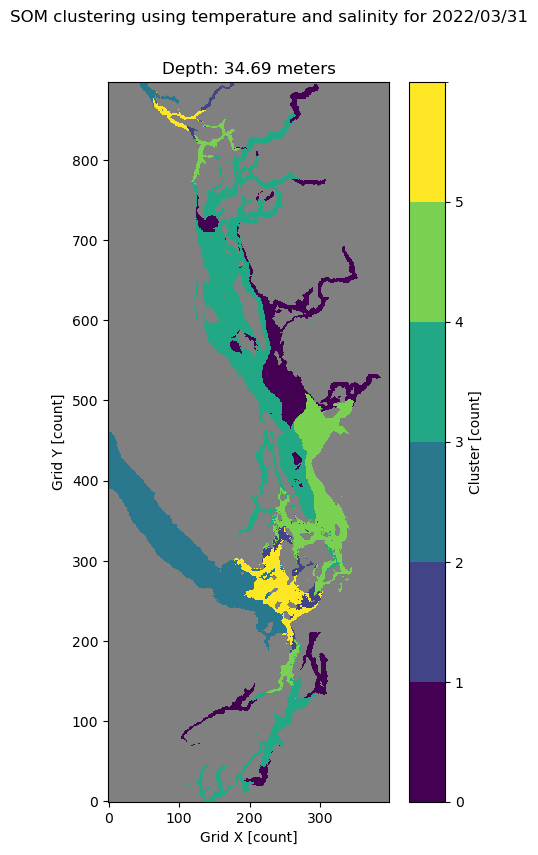

The amount of grid boxes for cluster 0 is 20530 

The minimum temperature for cluster 0 is 7.62 degrees Celsius
The maximum temperature for cluster 0 is 8.73 degrees Celsius
The mean temperature for cluster 0 is 8.31 degrees Celsius 

The minimum salinity for cluster 0 is 26.9 g/kg
The maximum salinity for cluster 0 is 29.8 g/kg
The mean salinity for cluster 0 is 29.44 g/kg 


The amount of grid boxes for cluster 1 is 10934 

The minimum temperature for cluster 1 is 7.52 degrees Celsius
The maximum temperature for cluster 1 is 8.41 degrees Celsius
The mean temperature for cluster 1 is 7.97 degrees Celsius 

The minimum salinity for cluster 1 is 29.35 g/kg
The maximum salinity for cluster 1 is 30.14 g/kg
The mean salinity for cluster 1 is 29.79 g/kg 


The amount of grid boxes for cluster 2 is 4620 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 7.96 degrees Celsius
The mean temperature for cluster 2 is 7.74 degrees Celsius 

The 

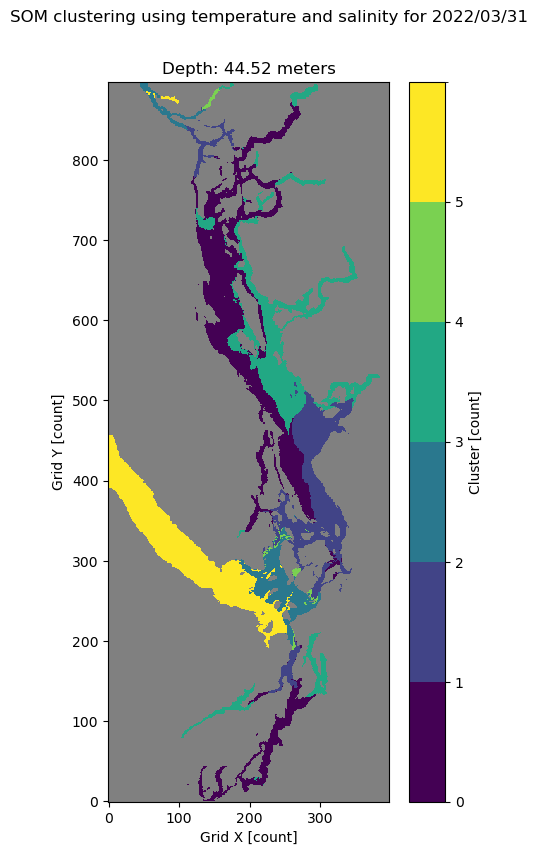

The amount of grid boxes for cluster 0 is 10821 

The minimum temperature for cluster 0 is 7.29 degrees Celsius
The maximum temperature for cluster 0 is 7.66 degrees Celsius
The mean temperature for cluster 0 is 7.46 degrees Celsius 

The minimum salinity for cluster 0 is 31.48 g/kg
The maximum salinity for cluster 0 is 33.17 g/kg
The mean salinity for cluster 0 is 32.13 g/kg 


The amount of grid boxes for cluster 1 is 1016 

The minimum temperature for cluster 1 is 7.59 degrees Celsius
The maximum temperature for cluster 1 is 7.91 degrees Celsius
The mean temperature for cluster 1 is 7.74 degrees Celsius 

The minimum salinity for cluster 1 is 30.38 g/kg
The maximum salinity for cluster 1 is 30.77 g/kg
The mean salinity for cluster 1 is 30.55 g/kg 


The amount of grid boxes for cluster 2 is 16884 

The minimum temperature for cluster 2 is 8.34 degrees Celsius
The maximum temperature for cluster 2 is 10.39 degrees Celsius
The mean temperature for cluster 2 is 8.8 degrees Celsius 

Th

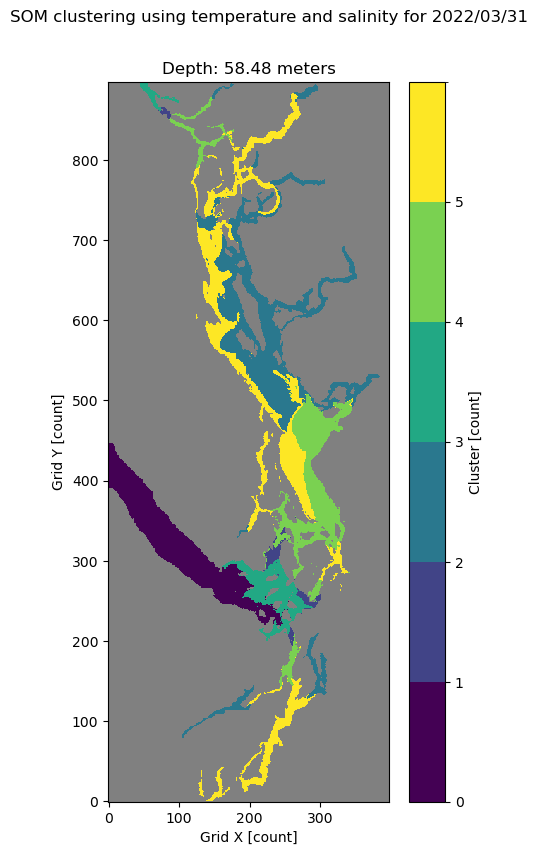

The amount of grid boxes for cluster 0 is 3617 

The minimum temperature for cluster 0 is 7.2 degrees Celsius
The maximum temperature for cluster 0 is 7.72 degrees Celsius
The mean temperature for cluster 0 is 7.57 degrees Celsius 

The minimum salinity for cluster 0 is 30.9 g/kg
The maximum salinity for cluster 0 is 31.92 g/kg
The mean salinity for cluster 0 is 31.45 g/kg 


The amount of grid boxes for cluster 1 is 8648 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 8.33 degrees Celsius
The mean temperature for cluster 1 is 7.85 degrees Celsius 

The minimum salinity for cluster 1 is 29.78 g/kg
The maximum salinity for cluster 1 is 30.81 g/kg
The mean salinity for cluster 1 is 30.11 g/kg 


The amount of grid boxes for cluster 2 is 11428 

The minimum temperature for cluster 2 is 7.62 degrees Celsius
The maximum temperature for cluster 2 is 8.62 degrees Celsius
The mean temperature for cluster 2 is 8.23 degrees Celsius 

The m

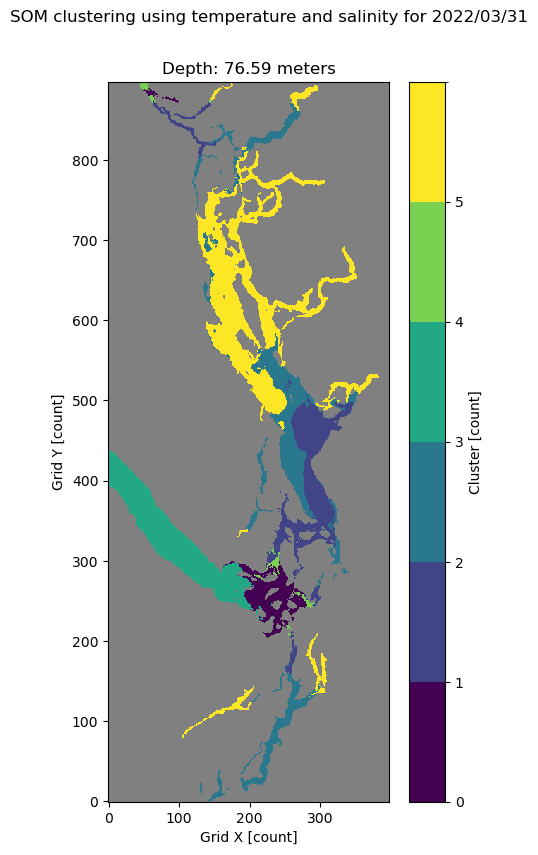

The amount of grid boxes for cluster 0 is 1936 

The minimum temperature for cluster 0 is 7.27 degrees Celsius
The maximum temperature for cluster 0 is 7.7 degrees Celsius
The mean temperature for cluster 0 is 7.55 degrees Celsius 

The minimum salinity for cluster 0 is 30.89 g/kg
The maximum salinity for cluster 0 is 31.96 g/kg
The mean salinity for cluster 0 is 31.49 g/kg 


The amount of grid boxes for cluster 1 is 10297 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 8.23 degrees Celsius
The mean temperature for cluster 1 is 7.88 degrees Celsius 

The minimum salinity for cluster 1 is 29.67 g/kg
The maximum salinity for cluster 1 is 30.75 g/kg
The mean salinity for cluster 1 is 30.14 g/kg 


The amount of grid boxes for cluster 2 is 8049 

The minimum temperature for cluster 2 is 7.67 degrees Celsius
The maximum temperature for cluster 2 is 8.71 degrees Celsius
The mean temperature for cluster 2 is 8.23 degrees Celsius 

The 

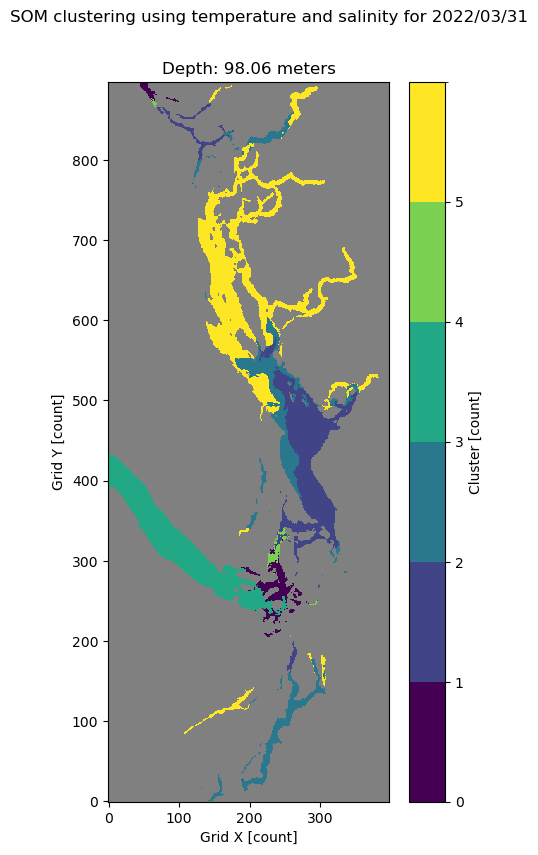

The amount of grid boxes for cluster 0 is 1160 

The minimum temperature for cluster 0 is 7.29 degrees Celsius
The maximum temperature for cluster 0 is 7.7 degrees Celsius
The mean temperature for cluster 0 is 7.62 degrees Celsius 

The minimum salinity for cluster 0 is 30.73 g/kg
The maximum salinity for cluster 0 is 31.84 g/kg
The mean salinity for cluster 0 is 31.1 g/kg 


The amount of grid boxes for cluster 1 is 13726 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 8.27 degrees Celsius
The mean temperature for cluster 1 is 7.93 degrees Celsius 

The minimum salinity for cluster 1 is 29.06 g/kg
The maximum salinity for cluster 1 is 30.74 g/kg
The mean salinity for cluster 1 is 30.2 g/kg 


The amount of grid boxes for cluster 2 is 3828 

The minimum temperature for cluster 2 is 8.19 degrees Celsius
The maximum temperature for cluster 2 is 8.83 degrees Celsius
The mean temperature for cluster 2 is 8.49 degrees Celsius 

The mi

IndexError: index 5 is out of bounds for axis 0 with size 5

In [140]:
ds, temp, saline, date, mask = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline = masking(depth, temp, saline, mask)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique)
